<a href="https://colab.research.google.com/github/vaibhavraok/GNCIPL/blob/main/E_commerce_User_Behavior_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo scipy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
online_retail = fetch_ucirepo(id=352)   # Online Retail dataset
df = pd.DataFrame(online_retail.data.original)

print("Shape before cleaning:", df.shape)
df.head()


Shape before cleaning: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("Shape after cleaning:", df.shape)

Shape after cleaning: (397924, 8)


In [4]:
import datetime

# Reference date = max date in dataset
ref_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                               # Frequency
    'Quantity': 'sum'                                   # Monetary (proxy)
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
print("\nRFM sample:\n", rfm.head())


RFM sample:
             Recency  Frequency  Monetary
CustomerID                              
12346.0         325          1     74215
12347.0           1        182      2458
12348.0          74         31      2341
12349.0          18         73       631
12350.0         309         17       197


In [5]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

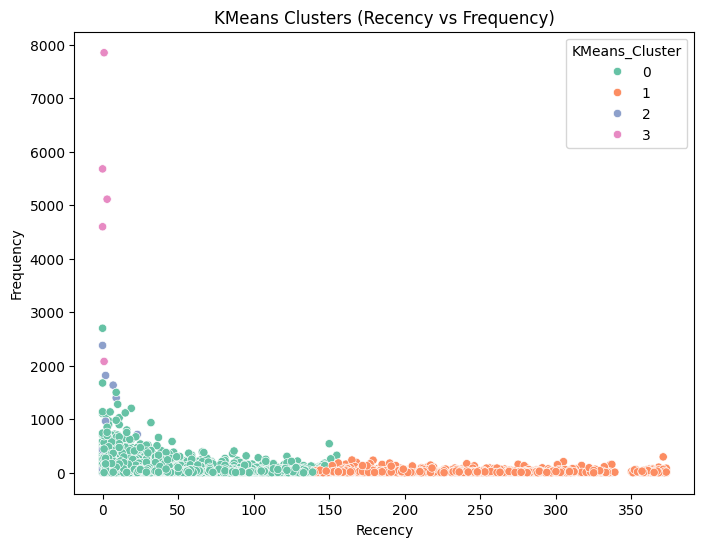

In [6]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x="Recency", y="Frequency", hue="KMeans_Cluster", data=rfm, palette="Set2")
plt.title("KMeans Clusters (Recency vs Frequency)")
plt.show()

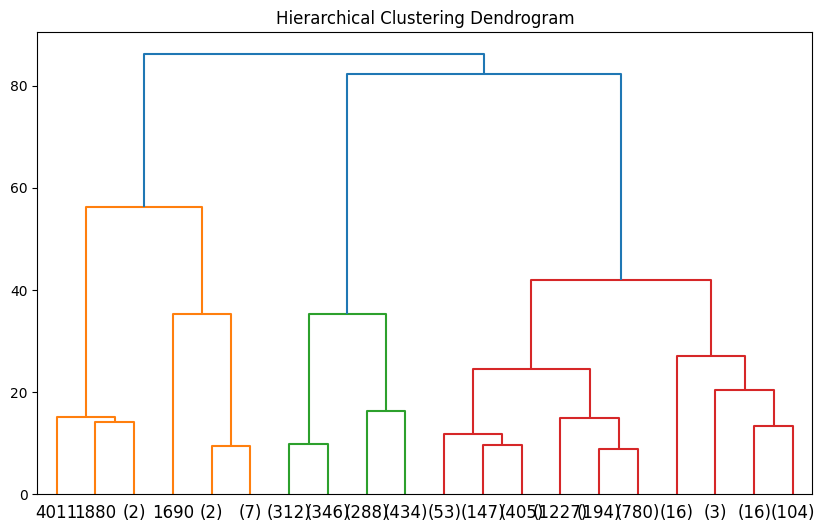

In [8]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

# Dendrogram
linked = linkage(rfm_scaled, method='ward')
plt.figure(figsize=(10,6))
dendrogram(linked, truncate_mode='lastp', p=20, show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

# Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
rfm['HC_Cluster'] = hc.fit_predict(rfm_scaled)


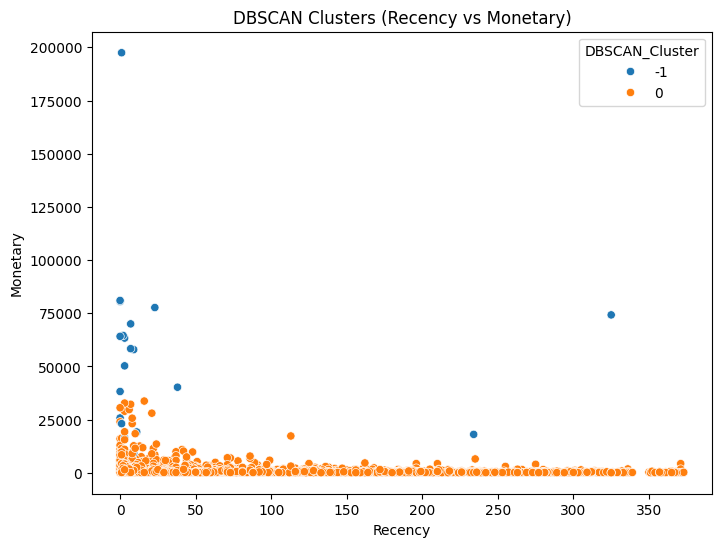

In [9]:
db = DBSCAN(eps=1.5, min_samples=10).fit(rfm_scaled)
rfm['DBSCAN_Cluster'] = db.labels_

plt.figure(figsize=(8,6))
sns.scatterplot(x="Recency", y="Monetary", hue="DBSCAN_Cluster", data=rfm, palette="tab10")
plt.title("DBSCAN Clusters (Recency vs Monetary)")
plt.show()

In [10]:
summary = rfm.groupby('KMeans_Cluster').mean()
print("\nCluster Summary (KMeans):\n", summary)


Cluster Summary (KMeans):
                    Recency    Frequency      Monetary  HC_Cluster  \
KMeans_Cluster                                                      
0                40.536299   102.152919   1094.557924    0.187828   
1               246.427112    27.739090    286.761374    1.998143   
2                23.750000   603.450000  49329.650000    0.450000   
3                 1.000000  5062.200000  68635.400000    2.600000   

                DBSCAN_Cluster  
KMeans_Cluster                  
0                    -0.001236  
1                    -0.000929  
2                    -0.650000  
3                    -1.000000  
